# A simple 1D model implementation


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from seapopym.configuration.no_transport.configuration import NoTransportConfiguration
from seapopym.configuration.no_transport.parameter import ForcingParameters, FunctionalGroups, NoTransportParameters
from seapopym.configuration.parameters.parameter_environment import (
    EnvironmentParameter,
    OutputParameter,
    PreProductionParameter,
)
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.configuration.parameters.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapopym.logging.custom_logger import set_verbose
from seapopym.model.no_transport_model import NoTransportModel
from seapopym.standard import coordinates
from seapopym.standard.units import StandardUnitsLabels

set_verbose()

## Generating data for the 1D simulation

Let's generate some data for the 1D simulation. In this NoTransport model, only temperature and primary production are required. The temperature is generated as a sine wave with a period of 1 year and the primary production is randomly generated.


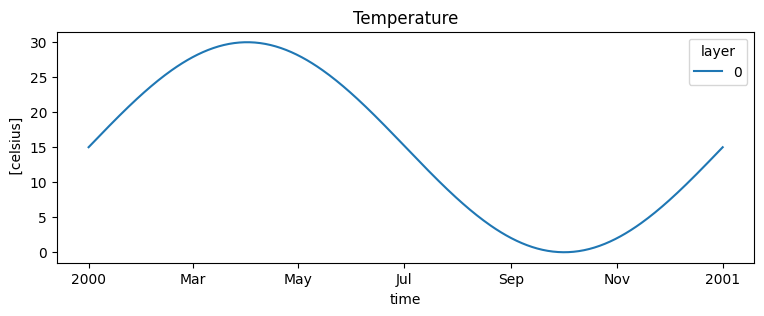

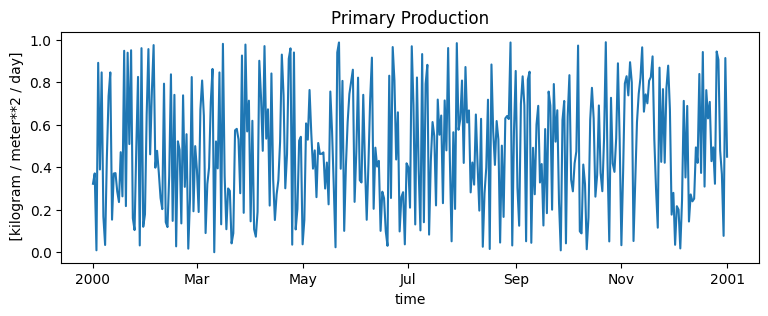

In [2]:
time_axis = coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D"))
n = int(time_axis.size)
t = np.linspace(0, 1, n)
temperature = 15 + 15 * np.sin(2 * np.pi * t)
primary_production = 10 + 5 * np.sin(2 * np.pi * t * 365)

temperature = xr.DataArray(
    dims=["time","latitude","longitude","layer"],
    coords={
        "time": coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "latitude": coordinates.new_latitude([0]),
        "longitude": coordinates.new_longitude([0]),
        "layer": coordinates.new_layer([0]),
    },
    attrs={"units": StandardUnitsLabels.temperature},
    data= temperature[:, np.newaxis, np.newaxis, np.newaxis]
)

plt.figure(figsize=(9,3))
temperature[:, 0, 0].cf.plot.line(x="T")
plt.title("Temperature")
plt.show()

primary_production = xr.DataArray(
    dims=["time","latitude","longitude"],
    coords={
        "time": coordinates.new_time(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "latitude": coordinates.new_latitude([0]),
        "longitude": coordinates.new_longitude([0]),
    },
    attrs={"units": StandardUnitsLabels.production},
    data=np.random.rand(367, 1, 1),
)

plt.figure(figsize=(9,3))
primary_production.plot()
plt.title("Primary Production")
plt.show()

dataset = xr.Dataset({"temperature": temperature, "primary_production": primary_production})

## Initialize the model

First we set up the model parameters. We will define a single functional group with the commonly used parameters for the zooplankton in Seapodym LMTL.


In [3]:
day_layer = 0
night_layer = 0
tr_max = 10.38
tr_rate = -0.11
inv_lambda_max = 150
inv_lambda_rate = 0.15

f_groups = FunctionalGroups(
    functional_groups=[
        FunctionalGroupUnit(
            name=f"D{day_layer}N{night_layer}",
            migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=day_layer, night_layer=night_layer),
            functional_type=FunctionalGroupUnitRelationParameters(
                inv_lambda_max=inv_lambda_max,
                inv_lambda_rate=inv_lambda_rate,
                temperature_recruitment_rate=tr_rate,
                cohorts_timesteps=[1] * np.ceil(tr_max).astype(int),
                temperature_recruitment_max=tr_max,
            ),
            energy_transfert=0.1668,
        )
    ]
)

p_param = ForcingParameters(
    temperature=ForcingUnit(forcing=dataset["temperature"], resolution=1),
    primary_production=ForcingUnit(forcing=dataset["primary_production"], resolution=1),
)

parameters = NoTransportParameters(
    functional_groups_parameters=f_groups,
    forcing_parameters=p_param,
    environment_parameters=EnvironmentParameter(
        output=OutputParameter(pre_production=PreProductionParameter(timestamps="all"))
    ),
)
no_transport_model = NoTransportModel(configuration=NoTransportConfiguration(parameters))
no_transport_model.state

<xarray.Dataset> Size: 9kB
Dimensions:                       (functional_group: 1, time: 367, latitude: 1,
                                   longitude: 1, layer: 1, cohort: 11)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * time                          (time) datetime64[ns] 3kB 2000-01-01 ... 20...
  * latitude                      (latitude) int64 8B 0
  * longitude                     (longitude) int64 8B 0
  * layer                         (layer) int64 8B 0
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables: (12/17)
    name                          (functional_group) <U4 16B 'D0N0'
    energy_transfert              (functional_group) float64 8B 0.1668
    inv_lambda_max                (functional_group) float64 8B 150.0
    inv_lambda_rate               (functional_group) float64 8B 0.15
    temperature_recruitment_max   (functional_group) float64 8B 10.38
    temperature_recruitment_rate  (functional_group) float64 8B -0.11
    ...                            ...
    resolution_latitude           float64 8B 1.0
    resolution_longitude          float64 8B 1.0
    timesteps_number              (functional_group, cohort) int64 88B 1 1 ... 1
    min_timestep                  (functional_group, cohort) int64 88B 1 ... 11
    max_timestep                  (functional_group, cohort) int64 88B 1 ... 11
    mean_timestep                 (functional_group, cohort) float64 88B 1.0 ...

## Run the model


In [4]:
no_transport_model.run()
no_transport_model.state.load()

2024-04-09 11:48:25,603 :: Seapodym ::  INFO ::
|	Computing production for Cohort 0



<xarray.Dataset> Size: 93kB
Dimensions:                       (functional_group: 1, time: 367, latitude: 1,
                                   longitude: 1, layer: 1, cohort: 11)
Coordinates:
  * functional_group              (functional_group) int64 8B 0
  * time                          (time) datetime64[ns] 3kB 2000-01-01 ... 20...
  * latitude                      (latitude) int64 8B 0
  * longitude                     (longitude) int64 8B 0
  * layer                         (layer) int64 8B 0
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables: (12/29)
    name                          (functional_group) <U4 16B 'D0N0'
    energy_transfert              (functional_group) float64 8B 0.1668
    inv_lambda_max                (functional_group) float64 8B 150.0
    inv_lambda_rate               (functional_group) float64 8B 0.15
    temperature_recruitment_max   (functional_group) float64 8B 10.38
    temperature_recruitment_rate  (functional_group) float64 8B -0.11
    ...                            ...
    mask_temperature              (functional_group, time, latitude, longitude, cohort) bool 4kB ...
    cell_area                     (latitude, longitude) float64 8B 1.236e+10
    mortality_field               (functional_group, time, latitude, longitude) float64 3kB ...
    recruited                     (functional_group, time, latitude, longitude, cohort) float64 32kB ...
    preproduction                 (functional_group, time, latitude, longitude, cohort) float64 32kB ...
    biomass                       (functional_group, time, latitude, longitude) float64 3kB ...

## Plotting the results

### The biomass evolution over time


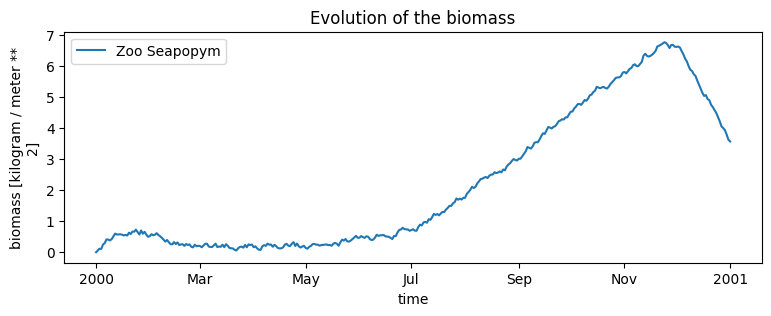

In [5]:
plt.figure(figsize=(9,3))
no_transport_model.plot_biomass(label="Zoo Seapopym")
plt.legend()
plt.title("Evolution of the biomass")
plt.show()

### And the production over time


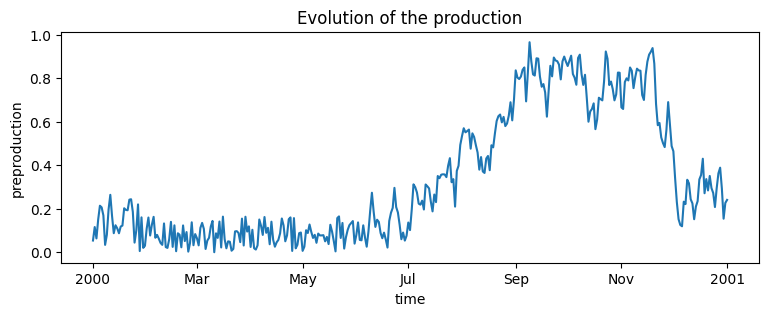

In [6]:
plt.figure(figsize=(9,3))
no_transport_model.state.preproduction[0].cf.mean(("X", "Y")).cf.sum("cohort").cf.plot.line(x="T")
plt.title("Evolution of the production")
plt.show()